### Homework 4 — CompSci 389 — University of Massachusetts — Spring 2022
Assigned: April 1, 2024;  Due: April 9, 2024 @ 11:59 PM EST

## Instructions!

In this assignment, you'll be using PyTorch again.  If you need to install PyTorch again, you can find instructions to install it [here](https://pytorch.org/get-started/locally/). Some Windows users have issue using pip to install it so I recommend in that case to use [anaconda](https://docs.conda.io/en/latest/miniconda.html). 

This time, we'll be using PyTorch to implement two types of neural network -- these are pretty cool.

The first of these is going to be an *autoencoder*.  An autoencoder is a neural network with a pretty unique structure, which will learn a function that can map an input to itself.  This allows the network to extract important features from an input to effectively compress it, and then reconstruct those important features back into something that approximates the original input closely.

The second of these is going to be a *GAN (generative adversarial network)*, which is a framework where we train two neural networks - one learns to generate synthetic data based on training data (the generator), and the other learns to distinguish true data from generated data (the discriminator).  This is where the word *adversarial* comes into the picture -- as the discriminator gets better at identifying fake data, the feedback is passed to the generator, which gets better at creating synthetic data.

One example of a cutting edge GAN that you can quickly check out is [This Person Does Not Exist](https://thispersondoesnotexist.com), which generates synthetic portraits of people!

In [1]:
# Step 1: Let's import some libraries!
import time
import torch
import torch.nn as nn
import torchvision
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision import datasets
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.image import imread
import os
import random
from tqdm import tqdm

In [2]:
# This is a new dependency to load this dataset, so make sure you install this module too
from PIL import Image

## Our Dataset
For this project we're going to use **human faces**! Well, *images* of human faces, but it's still cool. 

The particular dataset is calleb **CelebA** -- you can find the official website [here](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) and you can find the torchvision documentation [here](http://pytorch.org/vision/main/generated/torchvision.datasets.CelebA.html)


In [3]:
def load_celebA(batch_size=32, train=True):
    '''
    Dataset loading will be handled for you automatically since it's a bit of a pain
    to work with these large datasets and I'll just give you a subset
    '''

    dataset = []
    batch_counter = 0
    batch = []

    for file in tqdm(os.listdir('./celebA')):
        
        img = Image.open('./celebA/' + file)
        img = np.asarray(img).reshape(3, 109, 89)

        if batch_counter < batch_size:
            batch.append(img)
            batch_counter += 1
        else:
            dataset.append(np.array(batch))
            batch = []
            batch_counter = 0

    return np.array(dataset)


### Now let's see what our data looks like!

In [4]:
def plot_image(image):
    
    '''
    Takes in an image and shows it using matplotlib 
    this is used to visualize the data and also the outputs of our network
    '''

    image = image.reshape(-1, 109,89,3)

    plt.imshow(image[0])
    return

In [5]:
# This will load the dataset and set the dataset variable to it
# Try to only run this code once since it takes a while (though you may again to change the batch size)

dataset = load_celebA(batch_size=128, train=True)
dataset = torch.from_numpy(dataset)


100%|██████████| 10000/10000 [00:02<00:00, 4666.76it/s]


image shape: torch.Size([128, 3, 109, 89])


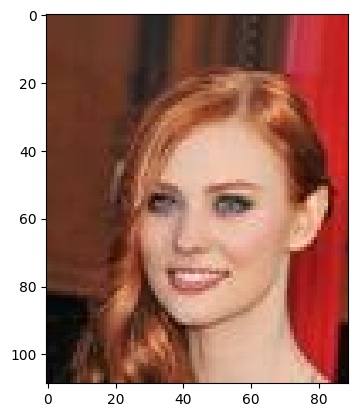

In [6]:
# This just displays a random image from the dataset 
ex_image = dataset[random.randint(0,77)]
print("image shape:", ex_image.shape)

plot_image(ex_image)


## Autoencoder (40 points)

Just like we did in HW3, we're doing to build a PyTorch ```nn.Module``` for our autoencoder.  Again, this consists of 2 parts: The initialization (defined in ```__init__()``` -- note that this the python convention for initalizing classes) and the forward pass (defined aptly as ```forward()```)

Since we're using PyTorch, we can simply define this module and then the gradient can be found *automatically*.

Documentation for a pytorch module can be found [here](https://pytorch.org/docs/stable/generated/torch.nn.Module.html)

##### Adam's little comment: guessing we'll want to put like a description of how to set up layers for the autoencoder here, depends on how much of a bottleneck we want.  I put some starter code below for an autoencoder on MNIST from this tutorial (minor changes for code readability): https://medium.com/pytorch/implementing-an-autoencoder-in-pytorch-19baa22647d1

Leaving this description blank for now since we haven't covered autoencoder in class...




In our first model we will just be creating a perceptron which will use a single ```nn.Linear()``` module -- you can find documentation for that [here](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)

In later models we'll use nonlinearities (and that neat convolution thing) -- documentation ```for nn.ReLU()``` can be found [here](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)


### Autoencoder Model (10 points)

Here you are going to make the module for your encoder and decoder -- the encoder will take an image as an input and compress it to some size (its a hyperparameter) and then the decoder will take that compressed (latent) representation of the image and try to reconstruct the original

In [7]:
def kernel_out_size(in_w, in_h, ker_size, stride=1):
    w = int((in_w - ker_size) / stride) + 1
    h = int((in_h - ker_size) / stride) + 1
    return w, h

In [8]:
class Encoder(nn.Module):

    '''
    This will be the module for your encoder half of your autoencoder
    You may use Linear layers, conv2d layers and anything else you'd like (you just need the first two)

    One thing that might throw you is that input_shape is going to be a tuple which represents the 
    entire shape of the input (i.e. an image is (3,109,89) in CelebA)
    ### TODO celebB change here
    '''

    def __init__(self, input_shape, compression_size):
        super().__init__()


        # TODO initialize the Encoder network 
        # You must use nn.Conv2d, nn.Linear, and nn.ReLU but you can look for anything else you'd like to use

        #################################################### 
        in_channels, in_width, in_height = input_shape

        k1 = 4
        self.conv1 = nn.Conv2d(in_channels, 1, k1)
        c1_out_w, c1_out_h = kernel_out_size(in_width, in_height, k1)
        final_size = c1_out_w * c1_out_h
        self.final_size = final_size

        self.lin1 = nn.Linear(final_size, final_size // 2)
        self.lin2 = nn.Linear(final_size // 2, final_size // 4)
        self.lin3 = nn.Linear(final_size // 4, final_size // 2)
        self.lin4 = nn.Linear(final_size // 2, compression_size)
        
        self.relu = nn.ReLU()

        #################################################### 

        self.flatten = nn.Flatten()


    def forward(self, features):

        features = features.view(-1, 3, 109, 89).float()
        
        #################################################### 

        x = self.conv1(features)
        x = x.reshape(-1, self.final_size)

        x = self.relu(self.lin1(x))
        x = self.relu(self.lin2(x))
        x = self.relu(self.lin3(x))
        x = self.lin4(x)
        out = x

        #################################################### 

        return out


In [9]:
encoder = Encoder((3,109,89), 100)
test_out = encoder(ex_image)

print(test_out.shape)
print("the shape of the output should be a vector of size batch_size,100, is it?")


torch.Size([128, 100])
the shape of the output should be a vector of size batch_size,100, is it?


In [10]:
class Decoder(nn.Module):
    '''
    This is the other bit of the autoencoder
    Likewise you can use whatever you'd like to get from the output of the encoder
    (which should be a vector )
    '''

    def __init__(self, input_size, output_shape):
        super().__init__()

        

        self.output_shape = output_shape

        # TODO initialize your Decoder
        # You can use Linear or conv layers as you'd like, but since we are expanding the size
        # You may want to look into deconvolution, which is called nn.Conv2Transpose

        ###############################################
        out_channel, out_w, out_h = output_shape

        k = 4
        kin_w, kin_h = kernel_out_size(out_w, out_h, k)
        final_size = kin_w * kin_h
        self.lin1 = nn.Linear(input_size, final_size // 4)
        self.lin2 = nn.Linear(final_size // 4, final_size // 2)
        self.lin3 = nn.Linear(final_size // 2, final_size)

        self.conv = nn.ConvTranspose2d(1, 3, k)
        self.relu = nn.ReLU()

        ###############################################



    def forward(self, x):

        # TODO finish the forward pass of your Decoder
        # Input is the output of the encoder

        ###############################################
        x = self.relu(self.lin1(x))
        x = self.relu(self.lin2(x))
        x = self.lin3(x)
        # x = self.relu(self.lin2(x))

        x = x.view(-1, 1, 106, 86)

        x = self.conv(x)
        out = x

        ###############################################
        
        return out

In [11]:
decoder = Decoder(100, (3,109,89))
test_out = decoder(torch.from_numpy(np.ones((32,100))).float())

print(test_out.shape)
print("the shape of the output should be shape (batch_size,3,109,89), is it?")

torch.Size([32, 3, 109, 89])
the shape of the output should be shape (batch_size,3,109,89), is it?


In [12]:
class Autoencoder(nn.Module):

    '''
    This will combine your encoder and decoder modules together
    with their powers combined they make an AUTOENCODER

    You may have issue with the shape of the input to the decoder
    remember that we pass in compression_size which will just be an int
    '''
    
    def __init__(self, input_shape, compression_size):
        super().__init__()
        
        self.input_size = input_shape

        self.encoder = Encoder(input_shape, compression_size)
        self.decoder = Decoder(compression_size, input_shape)
        self.relu = nn.ReLU()
        
        

    def forward(self, features):
        
        out = self.encoder(features)
        out = self.relu(out)
        out = self.decoder(out)
        
        return out

The original image


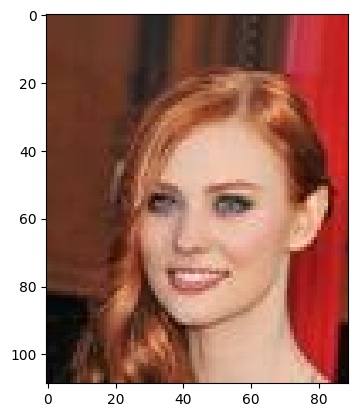

Your reconstruction


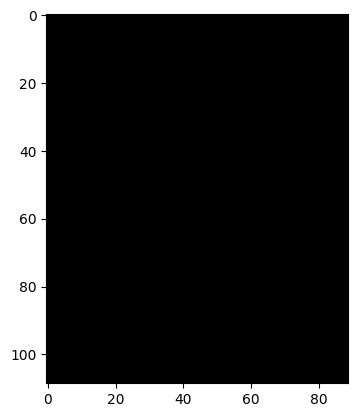

In [13]:
# Shows the prediction of the autoencoder without training
# Not very good huh? (though theres a small chance it is lol)

input_shape = (3,109,89)

test_model = Autoencoder(input_shape, 100) # Takes input of celebA image size and encodes it to size 100 and then decodes it
test_output = test_model(ex_image)

print("The original image")
plot_image(ex_image.byte())
plt.show()
print("Your reconstruction")
plot_image(test_output.detach().byte())

### Loss and Optimizer for Autoencoder (5 points)

The loss for our autoencoder is nice and easy since we can just compare the input and output directly -- MSE, MAE or any other loss you'd like would work, though you can try multiple to see how they behave (or make your own if you're a nerd)

Likewise we can use 




In [14]:
## Fill in the loss_function and optimizer below and run this cell to see if they are valid!

model = Autoencoder(input_shape, 100)
ex_image = ex_image.float().view(-1,3,109,89)                               

# TODO fill out the loss_function and optimizer

#############################################

lr = 0.01

loss_function = nn.CrossEntropyLoss()                                                    ## You can choose whichever loss function you'd like
optimizer = torch.optim.SGD(model.parameters(), lr=lr)                                                          ## You can use any optimizer for this, which is defined in torch.optim -- look up some API stuff

#############################################

# This checks that your model, loss and optimizer are valid
print("BEFORE GRADIENT STEP:")
ex_pred = model(ex_image)
ex_label = ex_image


optimizer.zero_grad() # Sets the gradient to 0 so that gradients don't stack together

ex_loss1 = loss_function(ex_pred, ex_label)
print("loss",ex_loss1.item())

ex_loss1.backward() # This gets the gradient of the loss function w.r.t all of your model's params

print()
print("AFTER GRADIENT STEP:")
optimizer.step() # This takes the step to train

ex_pred = model(ex_image)
ex_label = ex_image

ex_loss2 = loss_function(ex_pred, ex_label)
print("loss",ex_loss2.item())

print()
print("Difference in loss:", (ex_loss1 - ex_loss2).item())
print("This should be some positive number to say we reduced loss")


BEFORE GRADIENT STEP:
loss 357.20819091796875

AFTER GRADIENT STEP:
loss 356.60711669921875

Difference in loss: 0.60107421875
This should be some positive number to say we reduced loss


### Training Loop (10 points)
We're ready to train our autoencoder! Complete the ```training()``` function, just like in HW3. You can iterate over your data for 30 epochs to start. 

[Hint for reseting the optimizer](https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.zero_grad.html#torch.optim.Optimizer.zero_grad)

[Hint for stepping with the optimizer](https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.step.html#torch.optim.Optimizer.step) (You'll have to use .backward() to get the gradient)

At this point you should record your training and validation *losses* and *accuracies* **(four lists in total)**. You'll need these values for the written section, where you will be plotting them.

In [15]:
def autoencoder_training(model, loss_function, optimizer, train_data, n_epochs, update_interval):

    '''
    Updates the parameters of the given model using the optimizer of choice to
    reduce the given loss_function

    This will iterate over the dataloader 'n_epochs' times training on each batch of images
    
    To get the gradient (which is stored internally in the model) use .backward() from the loss tensor
    and to apply it use .step() on the optimizer

    In between steps you need to zero the gradient so it can be recalculated -- use .zero_grad for this
    '''
    
    losses = []

    for n in range(n_epochs):
        for i, image in enumerate(tqdm(train_data)):

            image = image.float().view(-1,3,109,89)

            # TODO Complete the training loop using the instructions above
            # Hint: the above code essentially does one training step

            ##############################################################
            optimizer.zero_grad()
            pred = model(image)
            loss = loss_function(pred, image)
            loss.backward()
            optimizer.step()


            ##############################################################
        
            if i % update_interval == 0:
                losses.append(round(loss.item(), 2)) # This will append your losses for plotting -- please use "loss" as the name for your loss
        
    return model, losses



100%|██████████| 77/77 [00:29<00:00,  2.63it/s]


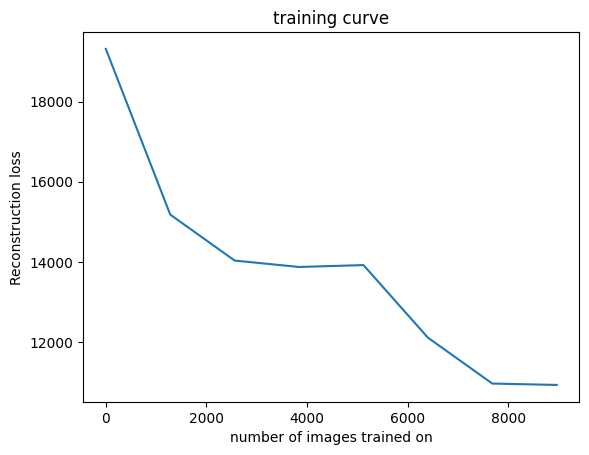

In [16]:
# Plug in your model, loss function, and optimizer 
# Try out different hyperparameters and different models to see how they perform

lr = 1e-4                # The size of the step taken when doing gradient descent
batch_size = 128         # The number of images being trained on at once
update_interval = 10     # The number of batches trained on before recording loss
n_epochs = 1            # The number of times we train through the entire dataset
compression_size = 200    # This is the size of the bottleneck (compression point) of the autoencoder

input_shape = (3,109,89)

dataset = dataset      # The dataset is a pain to load/unload so we want to keep it active

model = Autoencoder(input_shape, compression_size) 
loss_function = nn.MSELoss()                        
optimizer = torch.optim.Adam(model.parameters(), lr=lr) 

autoencoder_training_opt = torch.compile(autoencoder_training, mode="reduce-overhead") # This is compiles the training loop so that it runs faster (the first run will take much longer)

trained_model, losses = autoencoder_training(model, loss_function, optimizer, dataset, n_epochs=n_epochs, update_interval=update_interval)

plt.plot(np.arange(len(losses)) * batch_size * update_interval, losses)
plt.title("training curve")
plt.xlabel("number of images trained on")
plt.ylabel("Reconstruction loss")
plt.show()


# NOTE: It will take a while for this to train (depending on your model)
# You can increase the batch size (way up top) or reduce the size of your model if it takes too long


original image:


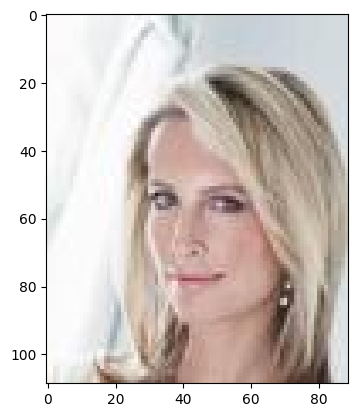

your (trained) reconstruction


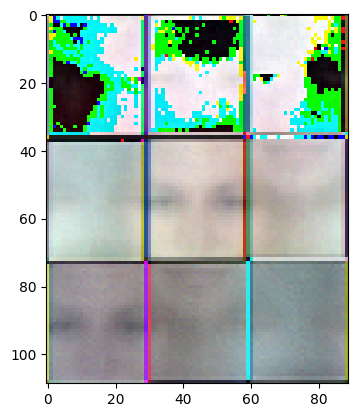

In [17]:
# Displays the reconstruction of the (now trained) autoencoder on the same example image
# Notice that it worked and we have a better prediction (if your code works)
ex_image = dataset[random.randint(0,len(dataset))]
trained_output = trained_model(ex_image)

print("original image:")
plot_image(ex_image)
plt.show()
print("your (trained) reconstruction")
plot_image(trained_output.detach().byte())

# NOTE: It is very likely that this won't look that good at first
# It may even give the same output independent of the input -- rerun this a few times to check
# Play with the hyperparameters until you're happy with the output

### Probably not great huh ^

Let's tune our hyperparameters so that we get something a bit cooler!

### Testing and HyperParameter Search (10 points)

Since the testing loop and training loop are so similar I'm going to go ahead and just give it to you -- but you gotta promise to at least look at the method to see how similar they are! 

In [18]:
def testing(model, loss_function, test_data):

    '''
    This function will test the given model on the given test_data
    it will return the accuracy and the test loss (given by loss_function) 
    '''
    
    sum_loss = 0

    for i, image in enumerate(tqdm(test_data)):

        # This is essentially exactly the same as the training loop 
        # without the, well, training, part
        
        pred = model(image)
        loss = loss_function(pred, image)
        sum_loss += loss.item()
    
    avg_loss = round(sum_loss / len(test_data), 2)

    # print("test loss:", avg_loss )

    return avg_loss

def train_and_test(model, loss_function, optimizer, batch_size, update_interval, n_epochs, train_dataset, test_dataset):

    '''
    This will use your/my methods to create a dataloader, train a gven model, and then test its performance

    Again, since I gave this to you for free you have to promise to look at it and try to understand it
    '''


    # training_opt = torch.compile(autoencoder_training, mode="reduce-overhead") # Once again we are compiling the training loop for speedup

    trained_model, losses = autoencoder_training(model, loss_function, optimizer, train_dataset, n_epochs=n_epochs, update_interval=update_interval)

    test_loss = testing(trained_model, loss_function, test_dataset)

    plt.plot(np.arange(len(losses)) * batch_size * update_interval, losses, color="b", label="train loss")
    plt.hlines(test_loss, 0, len(losses) * batch_size * update_interval, color='r', label="test loss")
    plt.legend()
    plt.title("training curve")
    plt.xlabel("number of images trained on")
    plt.ylabel("loss")
    plt.show()

    return trained_model, test_loss

In [19]:
avg_test_loss = testing(trained_model, loss_function, dataset[30:]) # you'll need to change this if you changed batch_size
print(avg_test_loss)

100%|██████████| 47/47 [00:03<00:00, 12.03it/s]

test loss: 10207.96
10207.96


In [29]:
#TODO Implement a hyperparameter search of your choice 
# I'm not going to give any hand-holdy code cause I believe in you! (and NOT because I'm lazy)

def find_hyperparams():

    train_dataset = dataset[0:60]
    test_dataset = dataset[60:]

    

    best_model, best_loss = None, float('inf')
    best_hyperparams = {}
    #######################################
    for lr_i in tqdm(range(1, 10), desc='lr'):
        # for batch_size in range(32, 128, 32):
        for n_epochs in range(1, 10):
            for c_size in range(50, 400, 25):
                # print(lr_i, n_epochs, c_size)
                lr = lr_i / (10 ** 2)
                m = Autoencoder(input_shape, c_size)

                # m = autoencoder_training_opt(m, nn.CrossEntropyLoss(), torch.optim.Adam(m.parameters, lr), batch_size, )
                m, _ = autoencoder_training(m, loss_function, torch.optim.Adam(m.parameters(), lr), train_dataset, n_epochs, update_interval)
                loss = testing(m, loss_function, test_dataset)
                # m, loss = train_and_test(
                #     m, nn.CrossEntropyLoss(), torch.optim.Adam(m.parameters(), lr), batch_size, 100, n_epochs, dataset[0:60], dataset[60:]
                # )

                if loss < best_loss:
                    m = best_model
                    best_loss = loss
                    best_hyperparams = {
                        'lr': lr,
                        # batch_size: batch_size,
                        'n_epochs': n_epochs,
                        'compression_size': c_size,
                    }
    
    return best_hyperparams, best_model, best_loss

hp, best_model, best_loss = find_hyperparams()

#######################################

lr:   0%|          | 0/4 [00:00<?, ?it/s]

1 1 50


100%|██████████| 17/17 [00:01<00:00, 13.30it/s]


test loss: 18269.75
1 1 75


100%|██████████| 17/17 [00:01<00:00, 13.24it/s]


test loss: 17439.12
1 1 100


100%|██████████| 17/17 [00:01<00:00, 12.98it/s]


test loss: 8265.27
1 1 125


100%|██████████| 17/17 [00:01<00:00, 13.43it/s]


test loss: 4229109.01
1 1 150


100%|██████████| 17/17 [00:01<00:00, 13.26it/s]


test loss: 13283.89
1 1 175


100%|██████████| 17/17 [00:01<00:00, 13.19it/s]


test loss: 17295.61
1 2 50


100%|██████████| 17/17 [00:01<00:00, 13.29it/s]


test loss: 16765.89
1 2 75


100%|██████████| 17/17 [00:01<00:00, 13.16it/s]


test loss: 11563.58
1 2 100


100%|██████████| 17/17 [00:01<00:00, 13.29it/s]


test loss: 17978.86
1 2 125


100%|██████████| 17/17 [00:01<00:00, 13.20it/s]


test loss: 9226.73
1 2 150


100%|██████████| 17/17 [00:01<00:00, 13.26it/s]


test loss: 8357.44
1 2 175


lr:  25%|██▌       | 1/4 [07:00<21:02, 420.98s/it]

test loss: 18239.31
2 1 50


100%|██████████| 17/17 [00:01<00:00, 13.31it/s]


test loss: 8306.5
2 1 75


100%|██████████| 17/17 [00:01<00:00, 13.60it/s]


test loss: 18085.34
2 1 100


100%|██████████| 17/17 [00:01<00:00, 13.34it/s]


test loss: 8172.43
2 1 125


100%|██████████| 17/17 [00:01<00:00, 13.34it/s]


test loss: 29836889630.12
2 1 150


100%|██████████| 17/17 [00:01<00:00, 13.38it/s]


test loss: 15401.8
2 1 175


100%|██████████| 17/17 [00:01<00:00, 13.24it/s]


test loss: 11078.6
2 2 50


100%|██████████| 17/17 [00:01<00:00, 12.22it/s]


test loss: 16597.91
2 2 75


100%|██████████| 17/17 [00:01<00:00, 13.59it/s]


test loss: 17597.35
2 2 100


100%|██████████| 17/17 [00:01<00:00, 13.60it/s]


test loss: 11246.99
2 2 125


100%|██████████| 17/17 [00:01<00:00, 13.53it/s]


test loss: 1347467576.7
2 2 150


100%|██████████| 17/17 [00:01<00:00, 13.38it/s]


test loss: 11306.1
2 2 175


lr:  50%|█████     | 2/4 [13:59<13:58, 419.24s/it]

test loss: 1538645662.12
3 1 50


100%|██████████| 17/17 [00:01<00:00, 13.42it/s]


test loss: 7097398.6
3 1 75


100%|██████████| 17/17 [00:01<00:00, 13.50it/s]


test loss: 9376.68
3 1 100


100%|██████████| 17/17 [00:01<00:00, 13.37it/s]


test loss: 7098.33
3 1 125


100%|██████████| 17/17 [00:01<00:00, 13.48it/s]


test loss: 705743957385697.9
3 1 150


100%|██████████| 17/17 [00:01<00:00, 13.39it/s]


test loss: 48460805346966.59
3 1 175


100%|██████████| 17/17 [00:01<00:00, 13.38it/s]


test loss: 7493.45
3 2 50


100%|██████████| 17/17 [00:01<00:00, 13.41it/s]


test loss: 12112.52
3 2 75


100%|██████████| 17/17 [00:01<00:00, 13.74it/s]


test loss: 14733.82
3 2 100


100%|██████████| 17/17 [00:01<00:00, 13.41it/s]


test loss: 11002.88
3 2 125


100%|██████████| 17/17 [00:01<00:00, 13.20it/s]


test loss: 2275082008696.47
3 2 150


100%|██████████| 17/17 [00:01<00:00, 13.68it/s]


test loss: 17920.58
3 2 175


lr:  75%|███████▌  | 3/4 [20:53<06:56, 416.89s/it]

test loss: 20103943.06
4 1 50


100%|██████████| 17/17 [00:01<00:00, 13.41it/s]


test loss: 1949362199030121.5
4 1 75


100%|██████████| 17/17 [00:01<00:00, 13.61it/s]


test loss: 1.328355092985496e+27
4 1 100


100%|██████████| 17/17 [00:01<00:00, 13.54it/s]


test loss: 1719692517811621.8
4 1 125


100%|██████████| 17/17 [00:01<00:00, 13.41it/s]


test loss: 4.525427279847009e+25
4 1 150


100%|██████████| 17/17 [00:01<00:00, 13.40it/s]


test loss: 1.7022878615120416e+27
4 1 175


100%|██████████| 17/17 [00:01<00:00, 13.53it/s]


test loss: 1.0070679934627592e+28
4 2 50


100%|██████████| 17/17 [00:01<00:00, 13.59it/s]


test loss: 1.1535284892950795e+27
4 2 75


100%|██████████| 17/17 [00:01<00:00, 13.25it/s]


test loss: 2.288499532349955e+26
4 2 100


100%|██████████| 17/17 [00:01<00:00, 13.41it/s]


test loss: 1.30483882338627e+27
4 2 125


100%|██████████| 17/17 [00:01<00:00, 13.23it/s]


test loss: 8643.95
4 2 150


100%|██████████| 17/17 [00:01<00:00, 13.06it/s]


test loss: 2.337164088634788e+25
4 2 175


lr: 100%|██████████| 4/4 [27:49<00:00, 417.45s/it]

test loss: 9.58338372907332e+26


In [30]:
print(hp, best_loss)

{0.03: 0.03, 1: 1, 200: 100} 7098.33


100%|██████████| 58/58 [00:04<00:00, 13.27it/s]


test loss: 7421.37


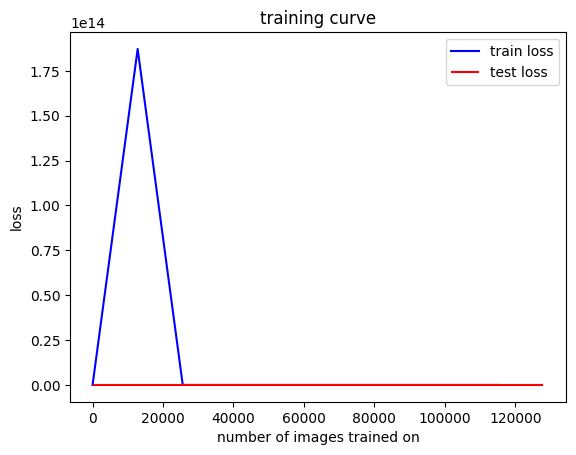

original image:


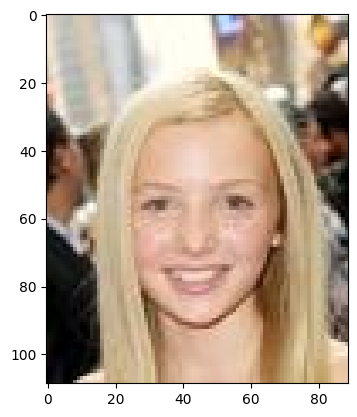

your (BEST) reconstruction


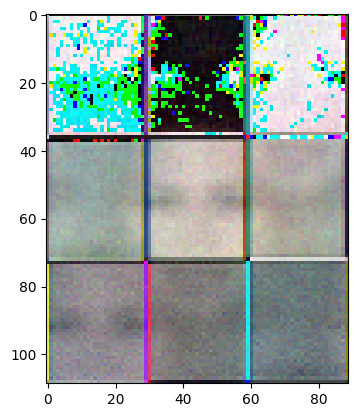

In [27]:
# Use your best hyperparameters -- your final test loss should be under 2000

lr = 1e-4               # The size of the step taken when doing gradient descent
batch_size = 128        # The number of images being trained on at once
update_interval = 100   # The number of batches trained on before recording loss
n_epochs = 10           # The number of times we train through the entire dataset
compression_size = 400  # The output size of the encoder

lr = 0.03
# n_epochs = 10
# compression_size = 200

model = Autoencoder(input_shape, compression_size) 
loss_function = nn.MSELoss()                        
optimizer = torch.optim.Adam(model.parameters(), lr=lr) 

train_dataset = dataset[:3 * len(dataset)//4]
test_dataset = dataset[len(dataset)//4:]

best_model, _ = train_and_test(model, loss_function, optimizer, batch_size=batch_size, update_interval=update_interval, n_epochs=n_epochs, train_dataset=train_dataset, test_dataset=test_dataset)

ex_image = dataset[random.randint(0,len(dataset))]
trained_output = trained_model(ex_image)

print("original image:")
plot_image(ex_image)
plt.show()
print("your (BEST) reconstruction")
plot_image(trained_output.detach().byte())

# Try to get a reconstruction that you are happy with
# It is difficult though so try to set up a big search and go for a hike or something
# be warned that google collab sometimes cuts off after some time so be careful!

## Autoencoder Written Report (10 points)
Now, lets take a bit of break from implementing models and do some writing (I know you all love that right?)
Fill out your answer to each question in the empty markdown cell below each question.

1. What would happen if the compression size of your autoencoder was as large as the input image? Try it and tell me what you found out!

2. Was your model able to output any faces that were looking in different directions? Why do you think it would be hard for an autoencoder to learn to output faces with different orientations? 

## Generative Adversarial Network (60 points)

Now it's time for us to make a Generative Adversarial Network (GAN)! 

GANs contain a generator that generates an image based on a given dataset, and a discriminator (classifier) to distinguish whether an image is real or generated.

GANs are very similar to autoencoders in the sense that we will create two different models, but we will actually train them on different losses!

### The GAN model (20 points)

In this part you will create your model for both the Discriminator and Generator. The discriminator will take in an input the size of the images and output a bit which represents either real or fake (the discriminators geuss as to the input is real data or generated)

The generator will take in an input of some size (it will end up being noise but this wont come up in the model making part) and then output an "image" that is the same size as the real data. 

In [ ]:
class Discriminator(nn.Module):

    '''
    This will be your discriminator half of you GAN
    it will take in something of the shape of an image of a face

    it will then return either 0 or 1 depending on whether it
    believes the input is from the real distribution or not
    '''

    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        # TODO Initialize your discriminator
        # You can linear and conv layers -- as well as anything else you find (don't forget you nonlinearity) 
        # HINT: if it trains too slow try reducing the dimensions for your linera layers somehow
        ##################################### 





        ##################################### 

    def forward(self, x):

        # TODO fill out the forward pass of your model
        # Don't forget nonlinearities!
        ####################################





        ####################################

        x = nn.Sigmoid()(x) # This sigmoid will squish the outputs between 0 and 1 (you can change this if you'd like but some things may break)

        return x


In [ ]:
# This is the performance of the Discriminator (before training) on the example image (which should be 1)
# If you rerun this it should change since we are randomly initializing the model
discriminator = Discriminator((3,218,178))
ex_output = discriminator(ex_image.float())

plot_image(ex_image)
print("Output of the discriminator given this input:", ex_output[0].detach().numpy()[0])

In [ ]:
class Generator(nn.Module):
    def __init__(self, input_size, output_shape):
        super(Generator, self).__init__()

        # TODO
       ####################################
        


        ####################################

    def forward(self, x):
        # TODO
       ####################################
        


        ####################################
        return out

In [ ]:
# This will show the output of our generator before training (it's fine if its all black)
test_gen = Generator(128, (3, 109, 89))
noise = (torch.rand(1, 128) - 0.5) / 0.5
test_output = test_gen(noise)

plot_image(test_output.detach().byte())

### This is our generator's attempt at making something before training ^

Let's train it to see how it can improve! 

### Training Loop (20 points)
The training for a GAN is fundementally the same for all the other models we train with pytorch (zero grad, output, loss, loss backward, optimizer step). But we are going to do 2 seperate updates in each loop, with different losses!

For each loop you will calculate the loss for both the discriminator and generator and then update those models accordingly. Some code is provided to help you out, but not all of it! 

You should record your *losses* for both the generator and the discriminator **(two lists in total)**. You'll need these values for the written section, where you will be discussing them.

Then, use your wisdom from the autoencoder hyperparameter search to find good settings to all the hyperparamers and try your best to get your model to produce a face!

[Hint for reseting the optimizer](https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.zero_grad.html#torch.optim.Optimizer.zero_grad)

[Hint for stepping with the optimizer](https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.step.html#torch.optim.Optimizer.step) (You'll have to use .backward() to get the gradient)

In [ ]:
def training(generator, discriminator, loss, g_optimizer, d_optimizer, train_dataloader, n_epochs, update_interval, noise_samples):
    
    g_losses = []
    d_losses = []
    
    for epoch in range(n_epochs):
        for i, image in enumerate(tqdm(train_dataloader)):

            # Training the discriminator
            # Real inputs are actual images from the CelebA dataset
            # Fake inputs are from the generator
            # Real inputs should be classified as 1 and fake as 0
            
            image = image.float()
            
            real_classifications = discriminator(image)
            real_labels = torch.ones(image.shape[0])

            noise = (torch.rand(image.shape[0], noise_samples) - 0.5) / 0.5
            fake_inputs = generator(noise)
            fake_classifications = discriminator(fake_inputs)
            fake_labels = torch.zeros(image.shape[0])

            classifications = torch.cat((real_classifications, fake_classifications), 0).reshape(len(real_classifications) + len(fake_classifications))
            targets = torch.cat((real_labels, fake_labels), 0)

            # TODO Calculate the loss for the discriminator and apply the gradient
            # This is the same as a normal training loop!
            #######################################################





            #######################################################
            
            if i % update_interval == 0:
                d_losses.append(round(d_loss.item(), 2))
            

            # We do a seperate forward pass to update the gradient for the generator since 
            # Pytorch doesnt like us reusing the same computation graph (it makes one under the hood)
            noise = (torch.rand(image.shape[0], noise_samples) - 0.5) / 0.5
            fake_inputs = generator(noise)
            fake_classifications = discriminator(fake_inputs)
            fake_labels = torch.zeros(image.shape[0], 1)

            # TODO Calculate the loss for the generator and apply the gradient
            # HINT: the loss for the generator is essentially the opposite of the 
            # discriminators loss but doesnt care about the real examples (they dont go through the generator at all)
            #######################################################




            ########################################################

            if i % update_interval == 0:
                g_losses.append(round(g_loss.item(), 2))
                
    return (generator, discriminator), (g_losses, d_losses) 

In [ ]:
lr = 2e-4               # The size of the step taken when doing gradient descent
batch_size = 64         # The number of images being trained on at once
update_interval = 100   # The number of batches trained on before recording loss
n_epochs = 1            # The number of times we train through the entire dataset
noise_samples = 1024    # The size of the noise input to the Generator

loss_function = nn.BCELoss()

G_model = Generator(noise_samples, (3,109,89))
D_model = Discriminator((3,109,89))
G_optimizer = torch.optim.Adam(G_model.parameters(), lr=lr*2)     # This is an improved version of SGD which decreases the learning rate over time to avoid leaving a minima
D_optimizer = torch.optim.Adam(D_model.parameters(), lr=lr)       # This is an improved version of SGD which decreases the learning rate over time to avoid leaving a minima

train_dataset = dataset

models, losses = training(G_model, D_model, loss_function, G_optimizer, D_optimizer, train_dataset, n_epochs, update_interval, noise_samples)

G_model, D_model = models
g_losses, d_losses = losses

plt.plot(np.arange(len(g_losses)) * batch_size * update_interval, g_losses)
plt.title("training curve for generator")
plt.xlabel("number of images trained on")
plt.ylabel("loss")
plt.show()

plt.plot(np.arange(len(d_losses)) * batch_size * update_interval, d_losses)
plt.title("training curve for discriminator")
plt.xlabel("number of images trained on")
plt.ylabel("loss")
plt.show()

Now let's take a look at the generated images coming out of our trained GAN!

In [ ]:
# This will show the same example as before with the discriminator's new score 
# 0 is fake and 1 is real -- is it good at discriminating?

trained_output = D_model(ex_image.float())

plot_image(ex_image)
print("Output of the discriminator given this input:", trained_output[0].detach().numpy()[0])
plt.show()

noise = (torch.rand(1, noise_samples) - 0.5) / 0.5
trained_gen = G_model(noise)

plot_image(trained_gen.detach())

trained_output = D_model(trained_gen.float())

print("Output of the discriminator given this generated input:", trained_output[0].detach().numpy()[0])

### GAN hyperparameter Search (10 points)

GANs are notoriously hard to train -- generally you have to do a lot of hyper parameter searching to 
find good settings. Try it out until you get results above that you're happy with it!
You're going to have to write a good amount of code for this, but you can base it off of what is above if you want

In [ ]:
# TODO Do a hyper parameter search and find the best settings for your model 
# Again I leave this up to you as to what to do, but I'm gonna warn you that trying them by hand 
# is probably going to be too slow to work
#######################################################


#######################################################

In [ ]:
# This will show the output of our *best* generator after training
noise = (torch.rand(1, 1024) - 0.5) / 0.5
trained_output = G_model(noise)

plot_image(trained_output.detach())

## GAN Written Report (10 points)
More writing, yay! Hopefully these questions will make you think!

1. Does your trained discriminator learn to correctly discriminate generated examples -- how does yours perform above? What would you guess is the ideal discriminator performance of a trained GAN? Why? 

2. Sometimes our generator can produce images that dont look at all like faces (to us) but still fools our discriminator. We can these exmaples *adverserial examples* for our disriminator. Why might our generator produce images like this instead of faces? 

## BONUSES (5 points each)

These are some extra questions that require more code or are just downright hard -- if you're interested in this stuff it could be fun though!

1. Write some code to augment your input to your autoencoder to either be black and white or occluded (part of the image missing) and train it to output the original unaugmented image. Show the results of your model after training below (you can edit whatever code you like to make this work)

2. After getting your generator able to generate faces (if you are able), show what it generates for some particular noise and then iteratively change the noise by a little bit. Does the generator produce faces that are similar for similar inputs?